# Earnings Beat or Earnings Miss Predictor
This GNN model will predict whether a company will beat or miss the next quarters earnings estimate based on fanancial data entered at the end of current quarter. <br>
**Concept:** A companies stock price generally tracks whether a company's earnings in a quarter are better or worse than expectations. One way to characterize the amount of an earnings beat or miss is to map percentages to an indicator function that can used in GNN classification task. For example a numerical range of [1,10] can map to the following earnings comparison:

-  lt -5%      -> 1
- [-5%, +5%]  -> 2
-  gt +5%      -> 3

In [6]:
import torch
import torch.nn as nn
import torch_geometric.nn as gnn
import torch_geometric.data as gdata
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import requests
import datetime as dt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import time
from tqdm.notebook import tqdm

In [7]:

def populate_node_target_features(ticker: str, node_grp: h5py.Group, target_grp: h5py.Group, n_quarters: int) -> None:
    # Get the data from the API 
    # Data dimension is [num_quarters, num_features] per company

    # Get all the quarterly data from the API for the company
    api_functions = ['EARNINGS', 'INCOME_STATEMENT', 'BALANCE_SHEET', 'CASH_FLOW', 'TIME_SERIES_MONTHLY_ADJUSTED']
    data = dict()
    for api_function in api_functions:
    
        url = f'https://www.alphavantage.co/query?function={api_function}&symbol={ticker}&apikey={api_key}'
        try:
            r = requests.get(url)
            data[api_function] = r.json()
            # pause 1 seconds between requests to avoid hitting the API request limit
            time.sleep(0.5)
            
        except:
            print(f'Error retrieving {api_function} data from API for ')
            return
    
    # Extract the quarterly data 
    # Stack the quarterly data into a matrix
    node_matrix = np.zeros((n_quarters, 17))
    target_matrix = np.zeros((n_quarters, 2))
    for qidx in range(n_quarters):
        # Get the features we want from the quarterly data
        features = []        
        # Income statement features
        income_statement = data['INCOME_STATEMENT']['quarterlyReports'][qidx]
        income_statement_features = [
            'totalRevenue',
            'operatingExpenses',
            'costofGoodsAndServicesSold'
        ]
        try:
            features.extend([income_statement[feature] for feature in income_statement_features])
        except:
            print(f'Error retrieving {feature} from income statement for {ticker}')
            return
        # Balance sheet features
        balance_sheet = data['BALANCE_SHEET']['quarterlyReports'][qidx]
        balance_sheet_features = [
            'totalAssets',
            'totalLiabilities',
            'commonStock',
            'currentAccountsPayable',
            'currentNetReceivables',
            'totalShareholderEquity',
        ]
        try:
            features.extend([balance_sheet[feature] for feature in balance_sheet_features])
        except:
            print(f'Error retrieving {feature} from balance sheet for {ticker}')
            return
        # Cash flow features
        cash_flow = data['CASH_FLOW']['quarterlyReports'][qidx]
        cash_flow_features = [
            'profitLoss',
            'dividendPayout',
            'capitalExpenditures',            
        ]
        try:
            features.extend([cash_flow[feature] for feature in cash_flow_features]) 
        except:
            print(f'Error retrieving {feature} from cash flow for {ticker}')
            return       
        # Earnings features
        earnings = data['EARNINGS']['quarterlyEarnings'][qidx]
        earnings_features = [
            'estimatedEPS',
            'reportedEPS',
        ]
        try:
            features.extend([earnings[feature] for feature in earnings_features])  
        except:
            print(f'Error retrieving {feature} from earnings for {ticker}')
            return

        # Time series features
        time_series = data['TIME_SERIES_MONTHLY_ADJUSTED']['Monthly Adjusted Time Series']
        # Get the date of the quarter end
        quarter_end_date = earnings['fiscalDateEnding']  
        # Extract the year and month from the date and convert to integers
        year = int(quarter_end_date[:4])
        month = int(quarter_end_date[5:7])
        # Get the monthy adjusted close price for each of the three months of the quarter
        # Have to match year and month because the day is not end of the month
        for i in range(3):       
            # Find the price key for the year and month we can to get the price for     
            price_key = [date for date in time_series.keys() if date[:7] == f'{year}-{month:02d}'][0]
            month_adj_close_price = time_series[price_key]['5. adjusted close']
            features.append(month_adj_close_price)
            # convert date to previous month date for the next price
            price_date = dt.datetime.strptime(price_key, '%Y-%m-%d')
            prev_month_date = price_date - dt.timedelta(days=31)
            year = prev_month_date.year
            month = prev_month_date.month
            
        # Convert feature array to numpy array and divide quarterly features by a billion to scale them
        # Convert any 'none' strings in the features list to 0
        features = [0 if feature == 'None' else feature for feature in features]        
        features = np.array(features, dtype=np.float32)
        features[:-5] /= 1e9
        # Store the features in the hdf5 file
        node_matrix[qidx, :] = features
        target_matrix[qidx, :] = np.array([earnings[feature] for feature in earnings_features], dtype=np.float32)
    node_grp[ticker] = node_matrix
    target_grp[ticker] = target_matrix
    

In [8]:

def populate_edge_features(pair: str, edge_grp: h5py.Group) -> None:
    # Get the data from the API
    # Data dimension is [1], one edge weight for each pair of companies

    # Get the company overview data for each of the companies in the pair
    (ticker1, ticker2) = pair.split('_')
    api_functions = ['OVERVIEW']
    data = dict()
    for ticker in (ticker1, ticker2):
        for api_function in api_functions:
            url = f'https://www.alphavantage.co/query?function={api_function}&symbol={ticker}&apikey={api_key}'
            try:
                r = requests.get(url)
                data[ticker] = r.json()
                time.sleep(0.5)
            except:
                print(f'Error retrieving {api_function} data from API')
                return
            
    # Get the features we want from the company overview data
    feature1 = []
    feature2 = []
    # Ticker 1 features
    feature1.extend([data[ticker1]['Sector'], data[ticker1]['Industry']])
    # Ticker 2 features
    feature2.extend([data[ticker2]['Sector'], data[ticker2]['Industry']])

    # create a feature string from each of the features
    feature1_str = ' '.join(feature1)
    feature2_str = ' '.join(feature2)

    # Use the sentence transformer to get the embeddings for the features
    model = SentenceTransformer('paraphrase-distilroberta-base-v1')
    feature1_embedding = model.encode(feature1_str)
    feature2_embedding = model.encode(feature2_str)
    # Convert the embeddings to a column vector
    feature1_embedding = feature1_embedding.reshape(1, -1)
    feature2_embedding = feature2_embedding.reshape(1, -1)    
    
    # Compute the cosine similarity between the embeddings
    edge_weight = cosine_similarity(feature1_embedding, feature2_embedding)

    # Store the edge weight in the hdf5 file
    edge_grp[pair] = edge_weight



In [9]:
# Gather and save the data we want to collect for each company so we don't have to do a lot of requests to the API
company_symbols = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']
# Alpha Vantage API key
api_key = 'IMSWKZZ2ILUS0FKX'
# Look for the data in the data folder
EBEMP_data_path = 'data/EBEMP_data_dow_11qtrs.hdf5'
# Specify the number of features we want to collect for each company
n_features = 17
# There will be multiple quarters of data for this graph, so we need to specify the number of quarters we want to include
n_quarters = 11
# Parameter that determines if companies are similar enough to be connected by an edge
edge_similarity_threshold = 0.5

def store_EBEMP_data(data_path=EBEMP_data_path, company_symbols=company_symbols, reprocess_features=False):
    
    def process_nodes():
        # For each company check if it's new because we might add new companies to the list of companies we want to include in our GNN
        nbar = tqdm(company_symbols)
        for ticker in nbar:
            nbar.set_description(f'Processing {ticker} node features')
            if ticker not in node_grp.keys():
                
                populate_node_target_features(ticker, node_grp, target_grp, n_quarters)
                # except:
                #     print(f'Error retrieving {ticker} data from API')
                #     EBEMP_data.close()
                #     return

    def process_edges():
        # Iterate through all unique pairs of companies and create a dataset for each pair if it doesn't exist to define the edge features
        # because there might be new ones in case they were added to the list of companies we want to include in our GNN
        ebar = tqdm(range(len(company_symbols)))
        for i in ebar:
            ebar.set_description(f'Processing {company_symbols[i]} edge features')
            for j in range(i+1, len(company_symbols)):
                pair = company_symbols[i] + '_' + company_symbols[j]
                if pair not in edge_grp.keys():
                    # If the edge pair is new, then compute the edge weight and create a hdf5 dataset to store it
                    try:
                        populate_edge_features(pair, edge_grp)
                    except:
                        print(f'Error processing edge features for {pair}')
                        EBEMP_data.close()
                        return
    
    # Two main cases here: 1) We want to reprocess all the features, or 2) Features are the same but we added new companies to GNN
    if os.path.exists(data_path) and reprocess_features:
        print('Deleting old data and reprocessing features')
        # Opening the file in write mode deletes all the data
        EBEMP_data = h5py.File(data_path, 'w')

        # Create a node group, edge, target, groups in the hdf5 file if they don't exist
        node_grp = EBEMP_data.create_group('nodes')
        edge_grp = EBEMP_data.create_group('edges')
        target_grp = EBEMP_data.create_group('targets')
       
        process_nodes()

        process_edges()        


    else:
        # Opening the file in append mode allows us to add new data without deleting the old data or create a new file if it doesn't exist
        print('Appending new data to existing file or creating new file if it does not exist')
        EBEMP_data = h5py.File(data_path, 'a')
        # Create a node group, edge, target, groups in the hdf5 file if they don't exist
        if 'nodes' not in EBEMP_data.keys():
            node_grp = EBEMP_data.create_group('nodes')
        if 'edges' not in EBEMP_data.keys():
            edge_grp = EBEMP_data.create_group('edges')
        if 'targets' not in EBEMP_data.keys():
            target_grp = EBEMP_data.create_group('targets')
        node_grp = EBEMP_data['/nodes']
        edge_grp = EBEMP_data['/edges']
        target_grp = EBEMP_data['/targets']
        
        process_nodes()
               
        process_edges()

        
    #close the hdf5 file
    EBEMP_data.close()
    
    
        

In [10]:
# Specify the companies we want to include in our GNN
#dow_list = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UTX', 'VZ', 'V', 'WBA', 'WMT', 'DIS']

# Get the EBEMP data
store_EBEMP_data(data_path=EBEMP_data_path, company_symbols=company_symbols, reprocess_features=False)

Appending new data to existing file or creating new file if it does not exist


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

## Generate training data from data file

In [20]:
## Retreive the EBEMP data, organize it into a PyTorch Geometric Data object and return the Data object
EBEMP_data_path = 'data/EBEMP_data_dow_11qtrs.hdf5'
edge_similarity_threshold = 0.5
# Open the hdf5 file for reading
EBEMP_data = h5py.File(EBEMP_data_path, 'r')
company_symbols = list(EBEMP_data['nodes'].keys())

node_grp = EBEMP_data['/nodes']
edge_grp = EBEMP_data['/edges']
target_grp = EBEMP_data['/targets']

# quarter indices for training, validation, and testing
# most reacent quarter is at index 0 but we need to use that data for the labels of the previous quarter
# so there is always at most n_quarters-1 quarters of data for training, validation, and testing

qtr_train = list(range(n_quarters-1, 2, -1)) 
qtr_val = list(range(n_quarters-1, 1, -1)) # validation is the second most recent quarter
qtr_test = list(range(n_quarters-1, 0, -1)) # testing is the second most recent quarter


#### Build the PyTorch Geometric Data object for the training data ####
## NODES and TARGETS ##
# Build the nodes, the newest quarters are at the beginning of the matrix so we need to reverse the order

## Train data ##

nodes_train = []
targets_train = []
for qidx in qtr_train:        
    for cidx, ticker in enumerate(company_symbols):
        # Get the node features for the company
        nodes_train.append(node_grp[ticker][qidx, :])
        # Compute the score for the next quarter as ground truth for training
        estEPS = target_grp[ticker][qidx-1, 0]
        repEPS = target_grp[ticker][qidx-1, 1]
        EPSratio = repEPS/estEPS
        # map to one-hot output targets
        if EPSratio > 1.05:
           score = 2
        elif EPSratio < 0.95:
            score = 1
        else:
            score = 0
        targets_train.append(score)

## Val data ##

nodes_val = []
targets_val = []
for qidx in qtr_val:        
    for cidx, ticker in enumerate(company_symbols):
        # Get the node features for the company
        nodes_val.append(node_grp[ticker][qidx, :])
        # Compute the score for the next quarter as ground truth for validation
        estEPS = target_grp[ticker][qidx-1, 0]
        repEPS = target_grp[ticker][qidx-1, 1]
        EPSratio = repEPS/estEPS
        # map to one-hot output targets
        if EPSratio > 1.05:
           score = 2
        elif EPSratio < 0.95:
            score = 1
        else:
            score = 0
        targets_val.append(score)

## Test data ##

nodes_test = []
targets_test = []
for qidx in qtr_test:        
    for cidx, ticker in enumerate(company_symbols):
        # Get the node features for the company
        nodes_test.append(node_grp[ticker][qidx, :])
        # Compute the score for the next quarter as ground truth for testing
        estEPS = target_grp[ticker][qidx-1, 0]
        repEPS = target_grp[ticker][qidx-1, 1]
        EPSratio = repEPS/estEPS
        # map to one-hot output targets
        if EPSratio > 1.05:
           score = 2
        elif EPSratio < 0.95:
            score = 1
        else:
            score = 0
        targets_test.append(score)


# the nodes list should have len(company_symbols)*len(qtr_trn) elements

## EDGES ##
# We need to define all the pairwise directed edges if the edge weight is above the similarity threshold
# but the edges in the data file are undirected so we need to check both directions
# This code defines all the outgoing edges from the current node

## Train data ##

edges_train_buf = []
for cidx, ticker in enumerate(company_symbols):
    # edges can be out of order in the hdf5 file so we need to check both directions
    for eidx in range(len(company_symbols)):
        pair = ticker + '_' + company_symbols[eidx]
        if pair in edge_grp.keys():
            if edge_grp[pair][0] > edge_similarity_threshold:
                edges_train_buf.append([cidx, eidx])
        # The ordering of the edge labels is unpredictable so we need to check both directions
        pair = company_symbols[eidx] + '_' + ticker
        if pair in edge_grp.keys():
            if edge_grp[pair][0] > edge_similarity_threshold:
                edges_train_buf.append([cidx, eidx])

# Each quarter of financial data basically repesents a layer of nodes that are connected.  The subsequent
# quarter is another layer with the same connections but different node indices.  So we just need to duplicate
# the node list with an offset for each quarter.
# Then we need to create a directed edge from older quarters to newer quarters nodes, so earlier node indices to 
# later node indices
edges_train = []
edges_cross_qtr = []
for i, qidx in enumerate(qtr_train):
    offset = i*len(company_symbols)
    edges_train.extend([[edge[0]+offset,edge[1]+offset] for edge in edges_train_buf])
    
for i, qidx in enumerate(qtr_train[:-1]):
    offset = i*len(company_symbols)    
    # create directed edges from older quarters to newer quarters nodes
    offset_plus = (i+1)*len(company_symbols)
    edges_cross_qtr.extend([[j+offset,j+offset_plus] for j in range(len(company_symbols))])
# Now put attach the cross quarter edges to the end of the full training edges
edges_train.extend(edges_cross_qtr)

## Val data ##

edges_val_buf = []
for cidx, ticker in enumerate(company_symbols):
    # edges can be out of order in the hdf5 file so we need to check both directions
    for eidx in range(len(company_symbols)):
        pair = ticker + '_' + company_symbols[eidx]
        if pair in edge_grp.keys():
            if edge_grp[pair][0] > edge_similarity_threshold:
                edges_val_buf.append([cidx, eidx])
        # The ordering of the edge labels is unpredictable so we need to check both directions
        pair = company_symbols[eidx] + '_' + ticker
        if pair in edge_grp.keys():
            if edge_grp[pair][0] > edge_similarity_threshold:
                edges_val_buf.append([cidx, eidx])

edges_val = []
edges_cross_qtr = []
for i, qidx in enumerate(qtr_val):
    offset = i*len(company_symbols)
    edges_val.extend([[edge[0]+offset,edge[1]+offset] for edge in edges_val_buf])
    
for i, qidx in enumerate(qtr_val[:-1]):
    offset = i*len(company_symbols)    
    # create directed edges from older quarters to newer quarters nodes
    offset_plus = (i+1)*len(company_symbols)
    edges_cross_qtr.extend([[j+offset,j+offset_plus] for j in range(len(company_symbols))])
# Now put attach the cross quarter edges to the end of the full validation edges
edges_val.extend(edges_cross_qtr)

## Test data ##

edges_test_buf = []
for cidx, ticker in enumerate(company_symbols):
    # edges can be out of order in the hdf5 file so we need to check both directions
    for eidx in range(len(company_symbols)):
        pair = ticker + '_' + company_symbols[eidx]
        if pair in edge_grp.keys():
            if edge_grp[pair][0] > edge_similarity_threshold:
                edges_test_buf.append([cidx, eidx])
        # The ordering of the edge labels is unpredictable so we need to check both directions
        pair = company_symbols[eidx] + '_' + ticker
        if pair in edge_grp.keys():
            if edge_grp[pair][0] > edge_similarity_threshold:
                edges_test_buf.append([cidx, eidx])

edges_test = []
edges_cross_qtr = []
for i, qidx in enumerate(qtr_test):
    offset = i*len(company_symbols)
    edges_test.extend([[edge[0]+offset,edge[1]+offset] for edge in edges_test_buf])
    
for i, qidx in enumerate(qtr_test[:-1]):
    offset = i*len(company_symbols)    
    # create directed edges from older quarters to newer quarters nodes
    offset_plus = (i+1)*len(company_symbols)
    edges_cross_qtr.extend([[j+offset,j+offset_plus] for j in range(len(company_symbols))])
# Now put attach the cross quarter edges to the end of the full testing edges
edges_test.extend(edges_cross_qtr)

EBEMP_data.close()

x = torch.tensor(np.array(nodes_train), dtype=torch.float)
y = torch.tensor(np.array(targets_train), dtype=torch.long)
edge_index = torch.tensor(np.array(edges_train), dtype=torch.long).t().contiguous()

data_train = gdata.Data(x=x, y=y, edge_index=edge_index)

x = torch.tensor(np.array(nodes_val), dtype=torch.float)
y = torch.tensor(np.array(targets_val), dtype=torch.long)
edge_index = torch.tensor(np.array(edges_val), dtype=torch.long).t().contiguous()

data_val = gdata.Data(x=x, y=y, edge_index=edge_index)

x = torch.tensor(np.array(nodes_test), dtype=torch.float)
y = torch.tensor(np.array(targets_test), dtype=torch.long)
edge_index = torch.tensor(np.array(edges_test), dtype=torch.long).t().contiguous()

data_test = gdata.Data(x=x, y=y, edge_index=edge_index)


## Data statistics

In [24]:
print(f'Number of nodes in training data: {data_train.num_nodes}')
print(f'Number of edges in training data: {data_train.num_edges}')
print(f'Number of nodes in validation data: {data_val.num_nodes}')
print(f'Number of edges in validation data: {data_val.num_edges}')
print(f'Number of nodes in testing data: {data_test.num_nodes}')
print(f'Number of edges in testing data: {data_test.num_edges}')
# Print the counts of each of the three classes in the training data
print(f'Number of class 0 nodes in training data: {torch.sum(data_train.y == 0)}')
print(f'Number of class 1 nodes in training data: {torch.sum(data_train.y == 1)}')
print(f'Number of class 2 nodes in training data: {torch.sum(data_train.y == 2)}')


Number of nodes in training data: 240
Number of edges in training data: 1474
Number of nodes in validation data: 270
Number of edges in validation data: 1662
Number of nodes in testing data: 300
Number of edges in testing data: 1850
Number of class 0 nodes in training data: 88
Number of class 1 nodes in training data: 18
Number of class 2 nodes in training data: 134


## Training the GNN

In [22]:
data_train.num_classes = 3

In [31]:
import torch.nn.functional as F

class EBEM_GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = gnn.GCNConv(data_train.num_node_features, 64)
        self.conv2 = gnn.GCNConv(64, 64)
        self.conv3 = gnn.GCNConv(64, data_train.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)

        return F.log_softmax(x, dim=1)

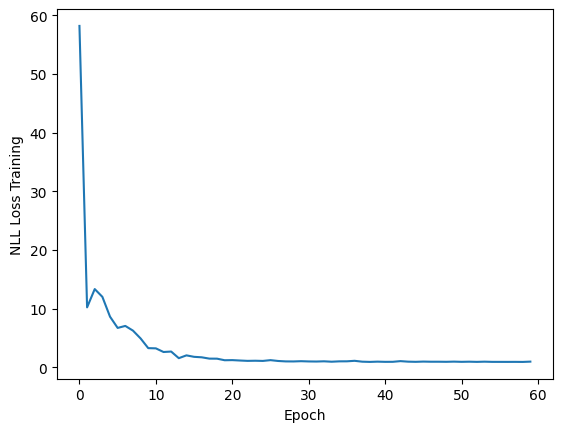

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EBEM_GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# capture the training loss and plot it
losses = []
model.train()
for epoch in range(60):
    optimizer.zero_grad()
    out = model(data_train)
    loss = F.nll_loss(out, data_train.y)
    loss.backward()
    optimizer.step()
    #print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, loss.item()))
    losses.append(loss.item())

# plot the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL Loss Training')
plt.show()


    

In [33]:
# Compute the accuracy on the training data
model.eval()
_, pred = model(data_train).max(dim=1)
correct = float(pred.eq(data_train.y).sum().item())
acc = correct / len(data_train.y)
print('Accuracy: {:.5f}'.format(acc))


Accuracy: 0.55833


In [34]:
# Compute the accuracy on the validation data
model.eval()
_, pred = model(data_train).max(dim=1)
val_set = pred[-len(company_symbols):]
tru_set = data_val.y[-len(company_symbols):]
correct = float(val_set.eq(tru_set).sum().item())
acc = correct / len(tru_set)
print('Accuracy: {:.5f}'.format(acc))



Accuracy: 0.40000
